In [533]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
warnings.simplefilter('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [534]:
url = "https://datadocs.bco-dmo.org/file/OJRrAA6hpQREv3/3782_v6_bats_bottle.csv"
df = pd.read_csv(url)
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20T22:30Z,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20T22:30Z,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [535]:
df['ISO_DateTime_UTC'] = pd.to_datetime(df['ISO_DateTime_UTC'],errors="coerce")#.astype('datetime64[s]')
df.head(2)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20 22:30:00+00:00,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20 22:30:00+00:00,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [ ]:
def make_depth_datasets(df, depths, time='ISO_DateTime_UTC'):
    
    datasets = {}
    
    for min_depth, max_depth, label in depths:

        filtered = df[(df['Depth'] >= min_depth) & (df['Depth'] <= max_depth)].copy()
        
        filtered['YearMonth'] = filtered[time].dt.to_period('M')
        filtered['Month'] = filtered[time].dt.month
        filtered['Year'] = filtered[time].dt.year
        
        datasets[label] = filtered
        
    return datasets

In [537]:
depth_ranges = [
    (0, 50, 'Surface'),
    (50, 200, 'Mid'),
    (200, 400, 'Deep'),
    # Add more ranges as needed
]
datasets = make_depth_datasets(df, depth_ranges)

In [554]:
#datasets["Surface"].groupby("Vessel")[["Latitude","Longitude"]].apply(lambda x: x.values)

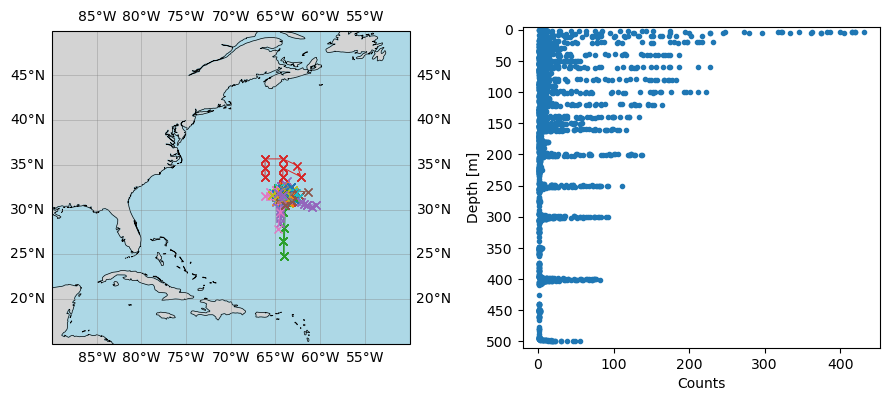

In [602]:
groups = datasets["Surface"].groupby("Cruise_ID")[["Latitude", "Longitude"]]

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, color='lightgray')
ax1.add_feature(cfeature.OCEAN, color='lightblue')
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

ax1.set_xlim(-90, -50)
ax1.set_ylim(15, 50)

for i, (cruise_id, group) in enumerate(groups):
    lon1, lat1 = group["Longitude"].iloc[0], group["Latitude"].iloc[0]
    lon2, lat2 = group["Longitude"].iloc[-1], group["Latitude"].iloc[-1]
    label = f"Cruise {cruise_id}"
    ax1.plot(group["Longitude"], group["Latitude"], marker="x", linestyle="-",
             linewidth=0.7, transform=ccrs.PlateCarree(), label=label)

ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

ax2 = fig.add_subplot(1, 2, 2)
counts = df[(df["Depth"] > 0) & (df["Depth"] < 500)].groupby('Depth')['ISO_DateTime_UTC'].count()
ax2.plot(counts, counts.index, marker=".", linestyle="")
ax2.set_yticks(range(0, 520, 50))
ax2.set_ylim(510, -5)
ax2.set_ylabel("Depth [m]")
ax2.set_xlabel("Counts")
plt.tight_layout()
fig.savefig("project/MetaRhythms/figures/map-cruise-id.png", dpi=300, bbox_inches="tight")

plt.show()

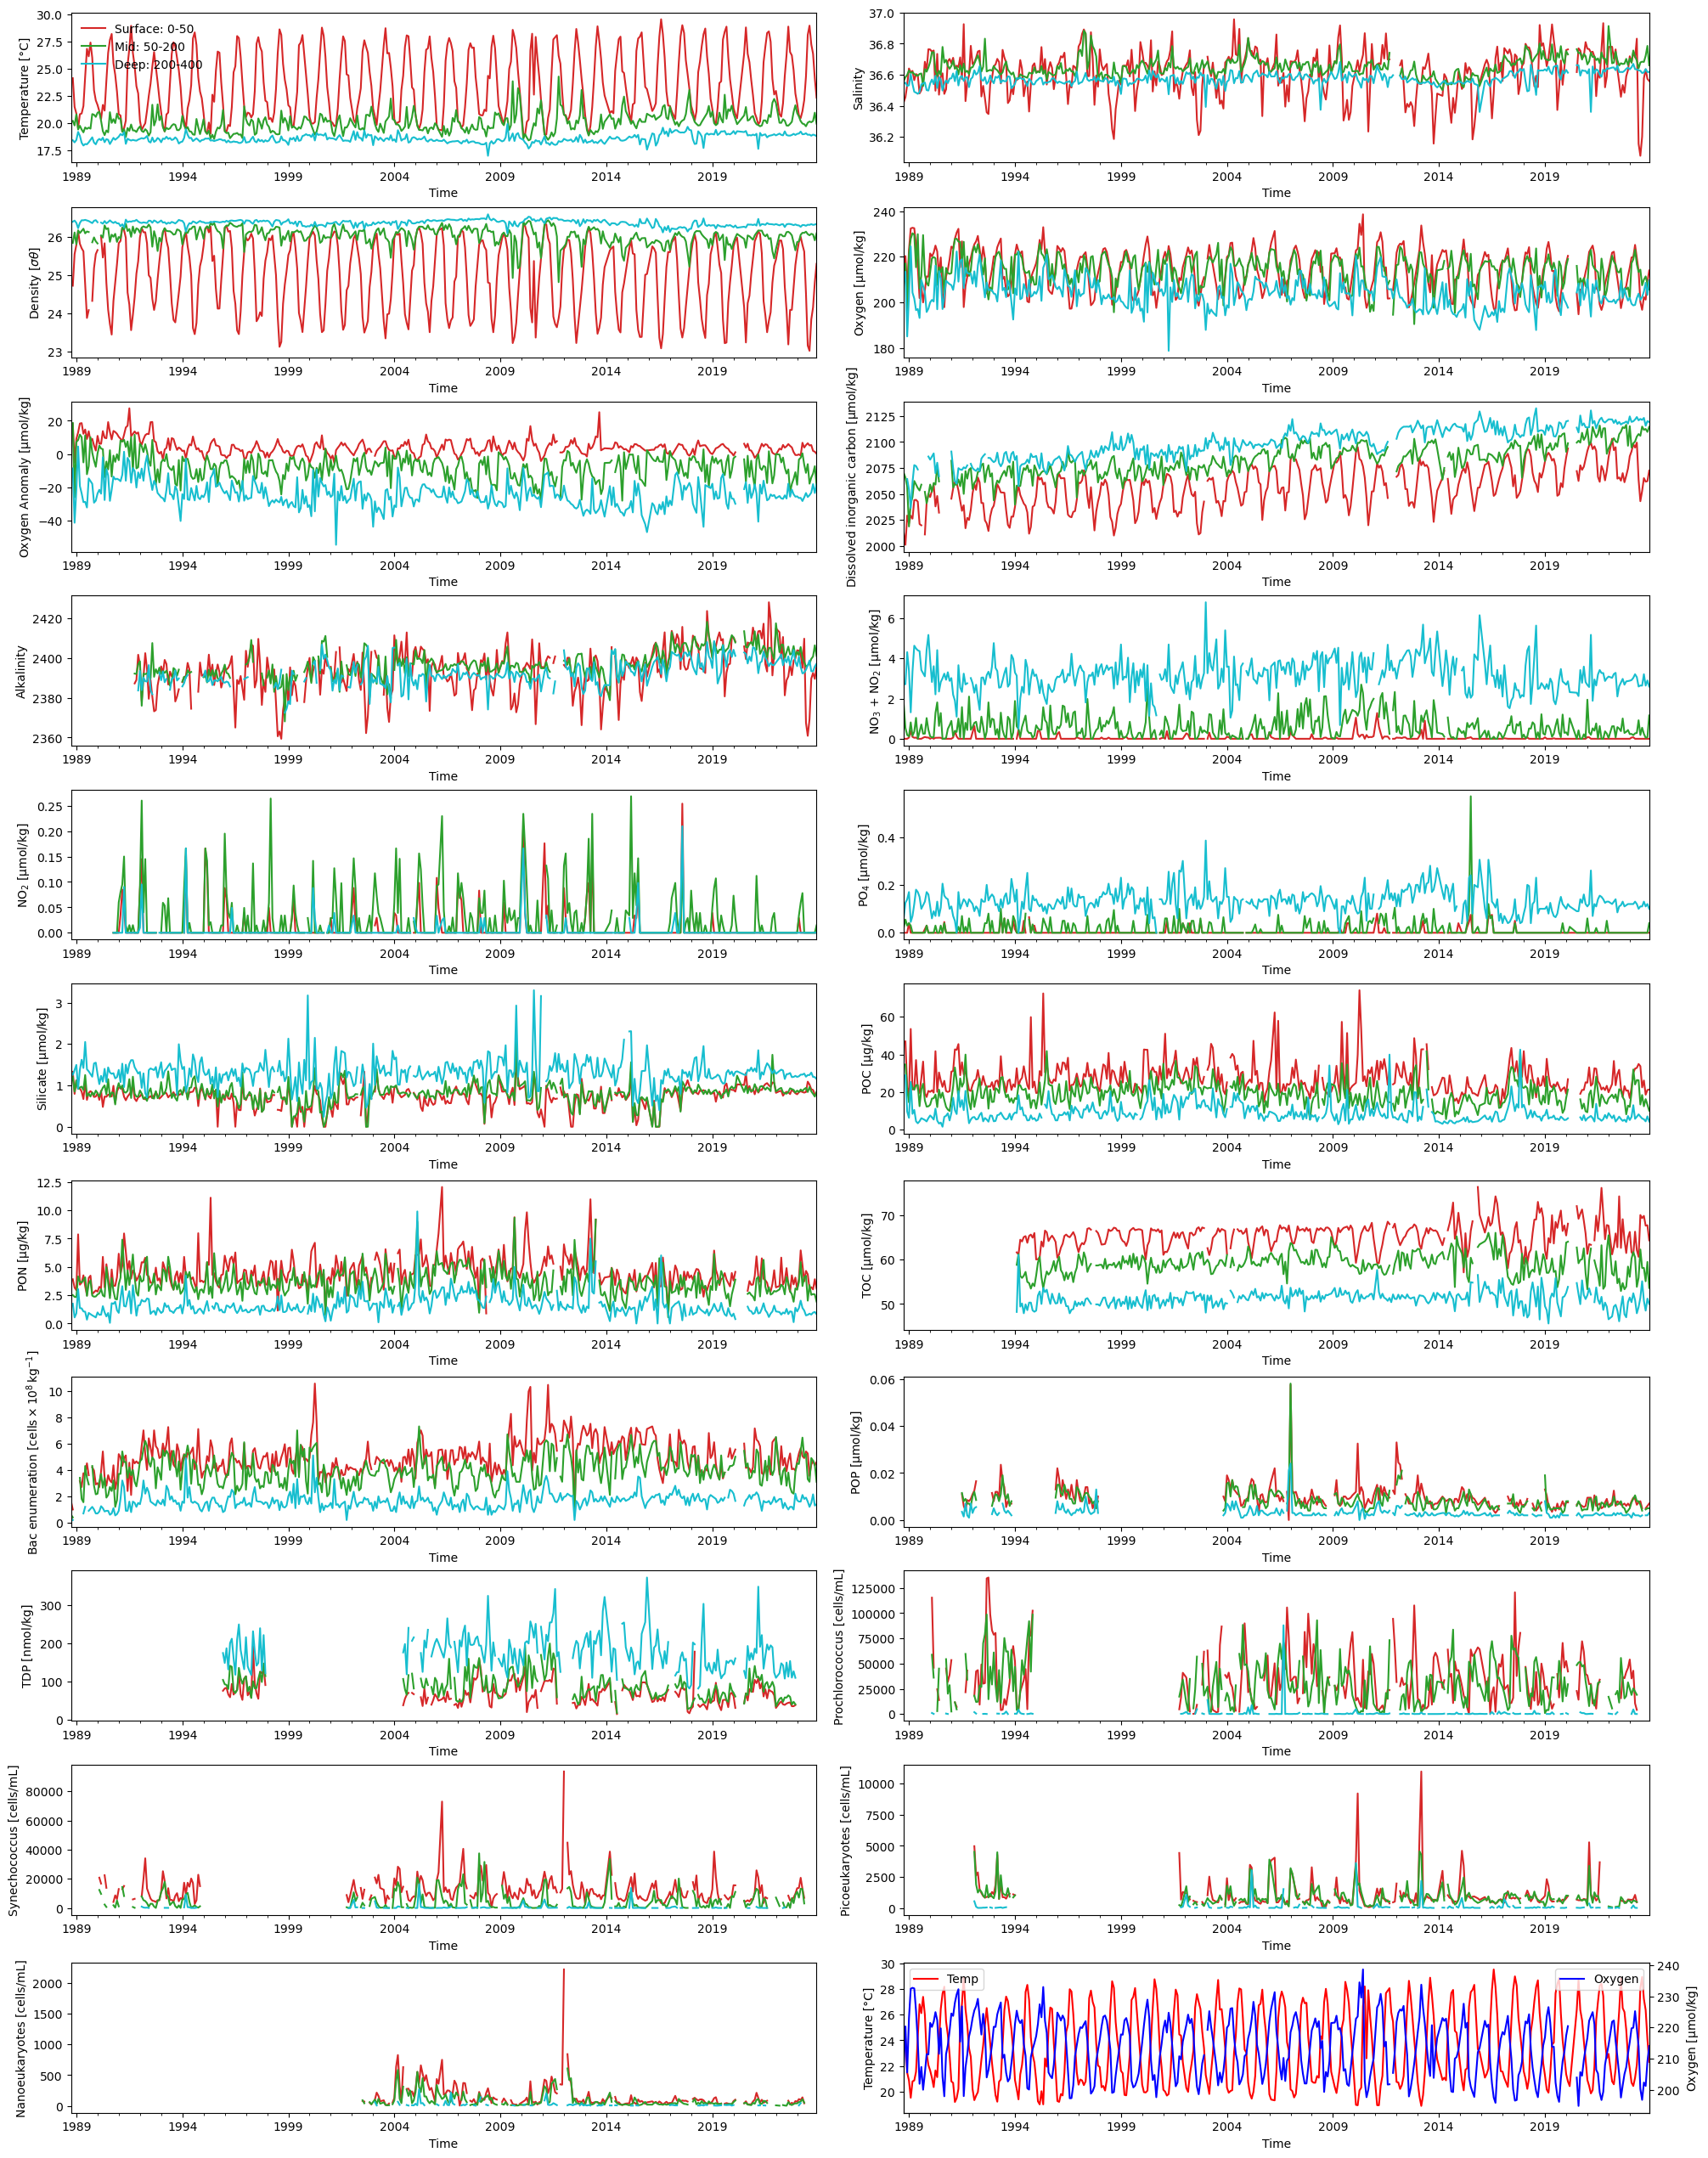

In [563]:
variables = [
    ("Temp", "Temperature [°C]"),
    ("Salinity", "Salinity"),
    ("Sigma_theta", r"Density [$\sigma\theta$]"),
    ("Oxygen", r"Oxygen [$\mathrm{\mu mol/kg}$]"),
    ("Oxygen_Anomaly", r"Oxygen Anomaly [$\mathrm{\mu mol/kg}$]"),
    ("CO2", r"Dissolved inorganic carbon [$\mathrm{\mu mol/kg}$]"),
    ("Alk", "Alkalinity"),
    ("NO3_plus_NO2", r"$\text{NO}_3$ + $\text{NO}_2$ [$\mathrm{\mu mol/kg}$]"),
    ("NO2", r"$\text{NO}_2$ [$\mathrm{\mu mol/kg}$]"),
    ("PO4", r"$\text{PO}_4$ [$\mathrm{\mu mol/kg}$]"), #$\text{PO}_4^{3-}$
    ("Silicate", r"Silicate [$\mathrm{\mu mol/kg}$]"), #$\text{SiO}_4^{4-}$
    ("POC", r"POC [$\mathrm{\mu g/kg}$]"),
    ("PON", r"PON [$\mathrm{\mu g/kg}$]"),
    ("TOC", r"TOC [$\mathrm{\mu mol/kg}$]"),
    ("Bact_Enum", r"Bac enumeration [$\text{cells} \times 10^8 \, \text{kg}^{-1}$]"),
    ("POP", r"POP [$\mathrm{\mu mol/kg}$]"),
    ("TDP", r"TDP [$\text{nmol/kg}$]"),#r"$\text{nmol/kg}$"
    ("Prochlorococcus", r"Prochlorococcus [cells/mL]"),
    ("Synechococcus", r"Synechococcus [cells/mL]"),
    ("Picoeukaryotes", r"Picoeukaryotes [cells/mL]"),
    ("Nanoeukaryotes", r"Nanoeukaryotes [cells/mL]")
]
n_vars = len(variables)
n_cols = 2
n_rows = -(-n_vars // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2.3), constrained_layout=True)
axes = axes.flatten()

for i, (var, ylabel) in enumerate(variables):
    ax = axes[i]

    datasets['Surface'].groupby('YearMonth')[var].median().plot(
        ax=ax, color='C3', label=f"Surface: {int(datasets['Surface'].Depth.min())}-{int(datasets['Surface'].Depth.max())}")
    datasets['Mid'].groupby('YearMonth')[var].median().plot(
        ax=ax, color='C2', label=f"Mid: {int(datasets['Mid'].Depth.min())}-{int(datasets['Mid'].Depth.max())}")
    datasets['Deep'].groupby('YearMonth')[var].median().plot(
        ax=ax, color='C9', label=f"Deep: {int(datasets['Deep'].Depth.min())}-{int(datasets['Deep'].Depth.max())}")

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")
    # ax.set_ylim(datasets['Surface'].groupby('YearMonth')[var].min().min())
    
    
    if i == 0:
        ax.legend(loc="upper left", frameon=False)
    else:
        ax.legend().set_visible(False)

ax = axes[len(variables)]
ax1 = ax
datasets['Surface'].groupby('YearMonth')["Temp"].median().plot(ax=ax1, color="r", label="Temp")
ax1.set_ylabel("Temperature [°C]")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
datasets['Surface'].groupby('YearMonth')["Oxygen"].median().plot(ax=ax2, color="b", label="Oxygen")
ax2.set_ylabel(r"Oxygen [$\mathrm{\mu mol/kg}$]")
ax1.legend(loc=2)
ax2.legend(loc=1)

for i in range(len(variables) + 1, len(axes)):
    fig.delaxes(axes[i])

fig.savefig("project/MetaRhythms/figures/long-ts-surf-mid-deep.png", dpi=300, bbox_inches="tight")
plt.show()

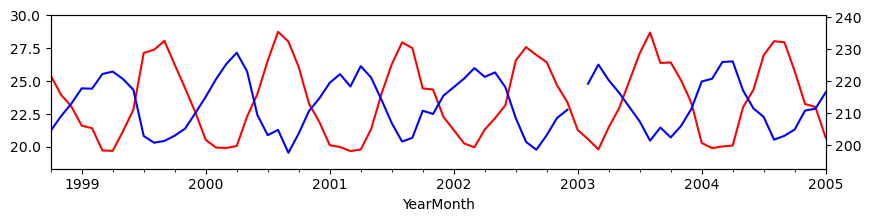

In [570]:
plt.figure(figsize=(10, 2))

ax1 = plt.gca()
datasets['Surface'].groupby('YearMonth')["Temp"].median().plot(ax=ax1, color="r")

ax2 = ax1.twinx()
datasets['Surface'].groupby('YearMonth')["Oxygen"].median().plot(ax=ax2, color="b")
plt.xlim(df.ISO_DateTime_UTC.values[10*1300],df.ISO_DateTime_UTC.values[10*2100])
# plt.savefig("project/MetaRhythms/figures/oxygen-temperature.png", dpi=300)
plt.show()

In [406]:
[col for col in enumerate(datasets["Surface"].columns)]

[(0, 'ISO_DateTime_UTC'),
 (1, 'Bottle_ID'),
 (2, 'Latitude'),
 (3, 'Longitude'),
 (4, 'Vessel'),
 (5, 'Cruise_ID'),
 (6, 'Cruise_type'),
 (7, 'Cruise_num'),
 (8, 'Cast_num'),
 (9, 'Bottle_num'),
 (10, 'QF_bottle'),
 (11, 'Depth'),
 (12, 'QF1_Depth'),
 (13, 'Temp'),
 (14, 'QF2_Temp'),
 (15, 'CTD_Salinity'),
 (16, 'QF3_CTD_Sal'),
 (17, 'Salinity'),
 (18, 'QF4_Salinity'),
 (19, 'Sigma_theta'),
 (20, 'QF5_Sigma_theta'),
 (21, 'Oxygen'),
 (22, 'QF6_Oxygen'),
 (23, 'Oxygen_Fix_Temp'),
 (24, 'QF7_Oxy_fix_temp'),
 (25, 'Oxygen_Anomaly'),
 (26, 'QF8_Oxy_anom'),
 (27, 'CO2'),
 (28, 'QF9_DIC'),
 (29, 'Alk'),
 (30, 'QF10_Alk'),
 (31, 'NO3_plus_NO2'),
 (32, 'QF11_NO3_NO2'),
 (33, 'NO2'),
 (34, 'QF12_NO2'),
 (35, 'PO4'),
 (36, 'QF13_PO4'),
 (37, 'Silicate'),
 (38, 'QF14_Silicate'),
 (39, 'POC'),
 (40, 'QF15_POC'),
 (41, 'PON'),
 (42, 'QF16_PON'),
 (43, 'TOC'),
 (44, 'QF17_TOC'),
 (45, 'TN'),
 (46, 'QF18_TN'),
 (47, 'Bact_Enum'),
 (48, 'QF19_Bact_enum'),
 (49, 'POP'),
 (50, 'QF20_POP'),
 (51, 'TDP')

Month
1     3.05
2     1.28
3     1.11
4     1.06
5     1.03
6     0.20
7     1.52
8     0.22
9     0.13
10    0.51
11    0.35
12    0.13
Name: NO3_plus_NO2, dtype: float64

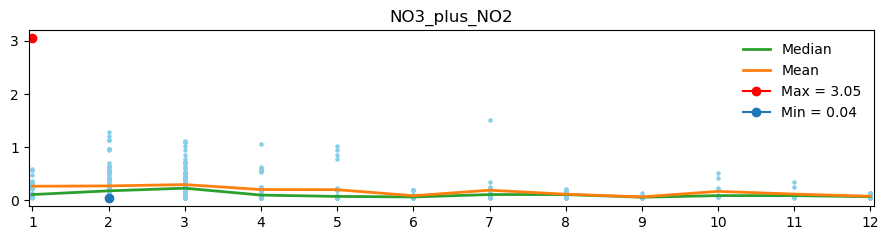

In [600]:
var=datasets["Surface"].columns[31]

# grouped_datasets = datasets["Mid"].groupby("Month")[var]
grouped_datasets = datasets["Surface"].loc[datasets["Surface"][var] != 0].groupby("Month")[var]


median_ds = grouped_datasets.median()
mean_ds = grouped_datasets.mean()
max_ds = grouped_datasets.max()
min_ds = grouped_datasets.min()
display(max_ds)

plt.figure(figsize=(9, 2.5))
# plt.subplot(1,2,1)
for group_name, group_data in grouped_datasets:
    plt.scatter([group_name] * len(group_data), group_data, color='skyblue',marker = "o",s=5, alpha=1)

plt.plot(median_ds.index, median_ds.values, color='C2', linewidth=2,label="Median")
plt.plot(mean_ds.index, mean_ds.values, color='C1', linewidth=2,label="Mean")
plt.plot(max_ds.idxmax(), max_ds.max(),color='r',marker='o',label=f"Max = {max_ds.max()}")
plt.plot(min_ds.idxmin(), min_ds.min(),color='C0',marker='o',label=f"Min = {min_ds.min()}")
#plt.plot(mean_ds.index,datasets["Surface"].loc[datasets["Surface"][var]==datasets["Surface"].groupby("Month")[var].max().max()]

# plt.xlabel("Date and Time (ISO_DateTime_UTC)")
#plt.ylabel("Temperature")
# plt.yscale('log')
plt.title(f"{var}")
plt.legend(bbox_to_anchor=(1, 1),frameon=False)
# plt.grid(True)
plt.xlim(0.95,12.05)
plt.xticks(range(1,13,1))
plt.tight_layout()
# plt.grid(True)
# plt.savefig("project/MetaRhythms/figures/monthly-NO2NO3-surf-min-max-samples-nozeros.png", dpi=300, bbox_inches="tight") #NO2NO3
plt.show()

In [309]:
def create_parameter_plots(datasets, param_config, layout=None, figsize=(14, 32)):
    n_params = len(param_config)
    n_datasets = len(datasets)
    if layout is None:
        layout = (n_params, n_datasets)
    
    rows, cols = layout
    fig = plt.figure(figsize=figsize)
    for param_idx, (param, config) in enumerate(param_config.items()):
        for dataset_idx, (df, label) in enumerate(datasets):
            plot_idx = param_idx * cols + dataset_idx + 1
            plt.subplot(rows, cols, plot_idx)
            data = df.query(config['query']) if config.get('query') else df
            if config.get('type', 'box') == 'line':
                sns.lineplot(data=data, 
                           x=config.get('x', 'Month'), 
                           y=param,
                           hue=config.get('hue'),
                           legend=config.get('legend', False))
            else:
                sns.boxplot(data=data, 
                          x=config.get('x', 'Month'), 
                          y=param,
                          legend=config.get('legend', False),
                          linewidth=1,
                          boxprops={'edgecolor': 'black', 'facecolor': 'skyblue'},
                          whiskerprops={'color': 'black'},
                          capprops={'color': 'black'},
                          medianprops={'color': 'black'},
                          flierprops={'markeredgecolor': 'black'})
                
                mean_values = data.groupby(config.get('x', 'Month'))[param].mean()
                # Get the actual month values present in the data
                unique_months = sorted(data[config.get('x', 'Month')].unique())
                # Reindex using the actual month values
                mean_values = mean_values.reindex(unique_months, fill_value=None)
                plt.plot(range(len(unique_months)), mean_values.values, 'o-', color='red', label='Mean')
            
            if config.get('log_scale'):
                plt.yscale("log")
            ylim = config.get('ylim')
            if isinstance(ylim, dict):
                depth_ylim = ylim.get(label)
                if depth_ylim:
                    plt.ylim(depth_ylim)
            elif ylim:
                plt.ylim(ylim)
                
            if config.get('xlim'):
                plt.xlim(config.get('xlim'))
            
    plt.subplots_adjust(
        hspace=config.get('hspace', 0.09), 
        wspace=config.get('wspace', 0.2)
    )
    
    return fig

In [580]:
def create_parameter_plots(datasets, param_config, layout=None, figsize=(14, 32)):
    n_params = len(param_config)
    n_datasets = len(datasets)
    if layout is None:
        layout = (n_params, n_datasets)
    
    # Define seasons with their months and colors
    seasons = {
        'Winter': ([12, 1, 2], 'lightblue', 0.3),
        'Spring': ([3, 4, 5], 'lightgreen', 0.3),
        'Summer': ([6, 7, 8], '#fabd07', 0.3),
        'Fall': ([9, 10, 11], '#f0700e', 0.3)
    }
    
    rows, cols = layout
    fig = plt.figure(figsize=figsize)
    for param_idx, (param, config) in enumerate(param_config.items()):
        for dataset_idx, (df, label) in enumerate(datasets):
            plot_idx = param_idx * cols + dataset_idx + 1
            ax = plt.subplot(rows, cols, plot_idx)
            data = df.query(config['query']) if config.get('query') else df
            
            # Add seasonal patches before plotting
            ymin, ymax = float('inf'), float('-inf')
            if not config.get('type', 'box') == 'line':
                ymin = min(data[param].min(), ymin)
                ymax = max(data[param].max(), ymax)
                
                # # Add some padding to the limits
                # yrange = ymax - ymin
                # ymin -= yrange * 0.1
                # ymax += yrange * 0.1
                
                # Add patches for each season
                for season, (months, color, alpha) in seasons.items():
                    for month in months:
                        # Convert month to 0-based index
                        month_idx = month - 1 if month != 12 else 11
                        rect = plt.Rectangle((month_idx - 0.5, ymin), 1, ymax - ymin,
                                          facecolor=color, alpha=alpha, zorder=0)
                        ax.add_patch(rect)
            
            if config.get('type', 'box') == 'line':
                sns.lineplot(data=data, 
                           x=config.get('x', 'Month'), 
                           y=param,
                           hue=config.get('hue'),
                           legend=config.get('legend', False))
            else:
                sns.boxplot(data=data, 
                          x=config.get('x', 'Month'), 
                          y=param,
                          legend=config.get('legend', False),
                          linewidth=1,
                          boxprops={'edgecolor': 'black', 'facecolor': 'skyblue'},
                          whiskerprops={'color': 'black'},
                          capprops={'color': 'black'},
                          medianprops={'color': 'black'},
                          flierprops={'markeredgecolor': 'black'})
                
                mean_values = data.groupby(config.get('x', 'Month'))[param].mean()
                unique_months = sorted(data[config.get('x', 'Month')].unique())
                mean_values = mean_values.reindex(unique_months, fill_value=None)
                plt.plot(range(len(unique_months)), mean_values.values, 'o-', color='red', label='Mean')
            
            if config.get('log_scale'):
                plt.yscale("log")
            ylim = config.get('ylim')
            if isinstance(ylim, dict):
                depth_ylim = ylim.get(label)
                if depth_ylim:
                    plt.ylim(depth_ylim)
            elif ylim:
                plt.ylim(ylim)
                
            if config.get('xlim'):
                plt.xlim(config.get('xlim'))
            
    plt.subplots_adjust(
        hspace=config.get('hspace', 0.09), 
        wspace=config.get('wspace', 0.2)
    )
    
    return fig

In [581]:
param_config = {
   'Temp': {
       'type': 'line',
       'ylim': {
           'Surface':[16,30],
           'Mid':[16,30],
           'Deep':[16,30]
       },
       'xlim': [1, 12],
       'hue': 'Year',
       'title': ''
   },
   'NO3_plus_NO2': {
       'type': 'box', 
       'query': 'NO3_plus_NO2>0', #[0.03, 1.3]
       'ylim': {
           'Surface':[0.02,6],
           'Mid':[0.02,6],
           'Deep':[0.02, 6]
       },
       'xlim': None,
       'title': ''
   },
   'PO4': {
       'type': 'box',
       'query': 'PO4>0', 
       'ylim': {
           'Surface':[0.02, 0.25],
           'Mid':[0.02, 0.25],
           'Deep':[0.02,0.25]
       },
       'xlim': None,
       'title': ''#
   },
   'Silicate': {
       'type': 'box',
       'query': 'Silicate>0',
       'ylim': [0.5, 1.8],
       'xlim': None,
       'title': ''
   },
   'Prochlorococcus': {
       'type': 'box',
       'query': 'Prochlorococcus>0',
       'ylim': [0, 12e4],
       'xlim': None,
       'title': ''
   },
   'Oxygen': {
       'type': 'box',
       'ylim': [190, 240],
       'xlim': None,
       'title': ''
   },
   'CO2': {
       'type': 'box',
       'ylim': [2020, 2130],
       'xlim': None,
       'title': ''
   },
    'TOC':{
        'type': 'box',
        'ylim': [30,80],
        'xlim': None,
        'title': ''
    }
}
#plt.ylim([2080,2130])
# common_settings = {
#    'legend': False,
#    'xlabel': 'Month',
#    'wspace': 0.2,
#    'hspace': 0.13
# }

# for param in param_config:
#    param_config[param].update(common_settings)

In [582]:
plot_datasets = [(df, label) for label, df in datasets.items()]

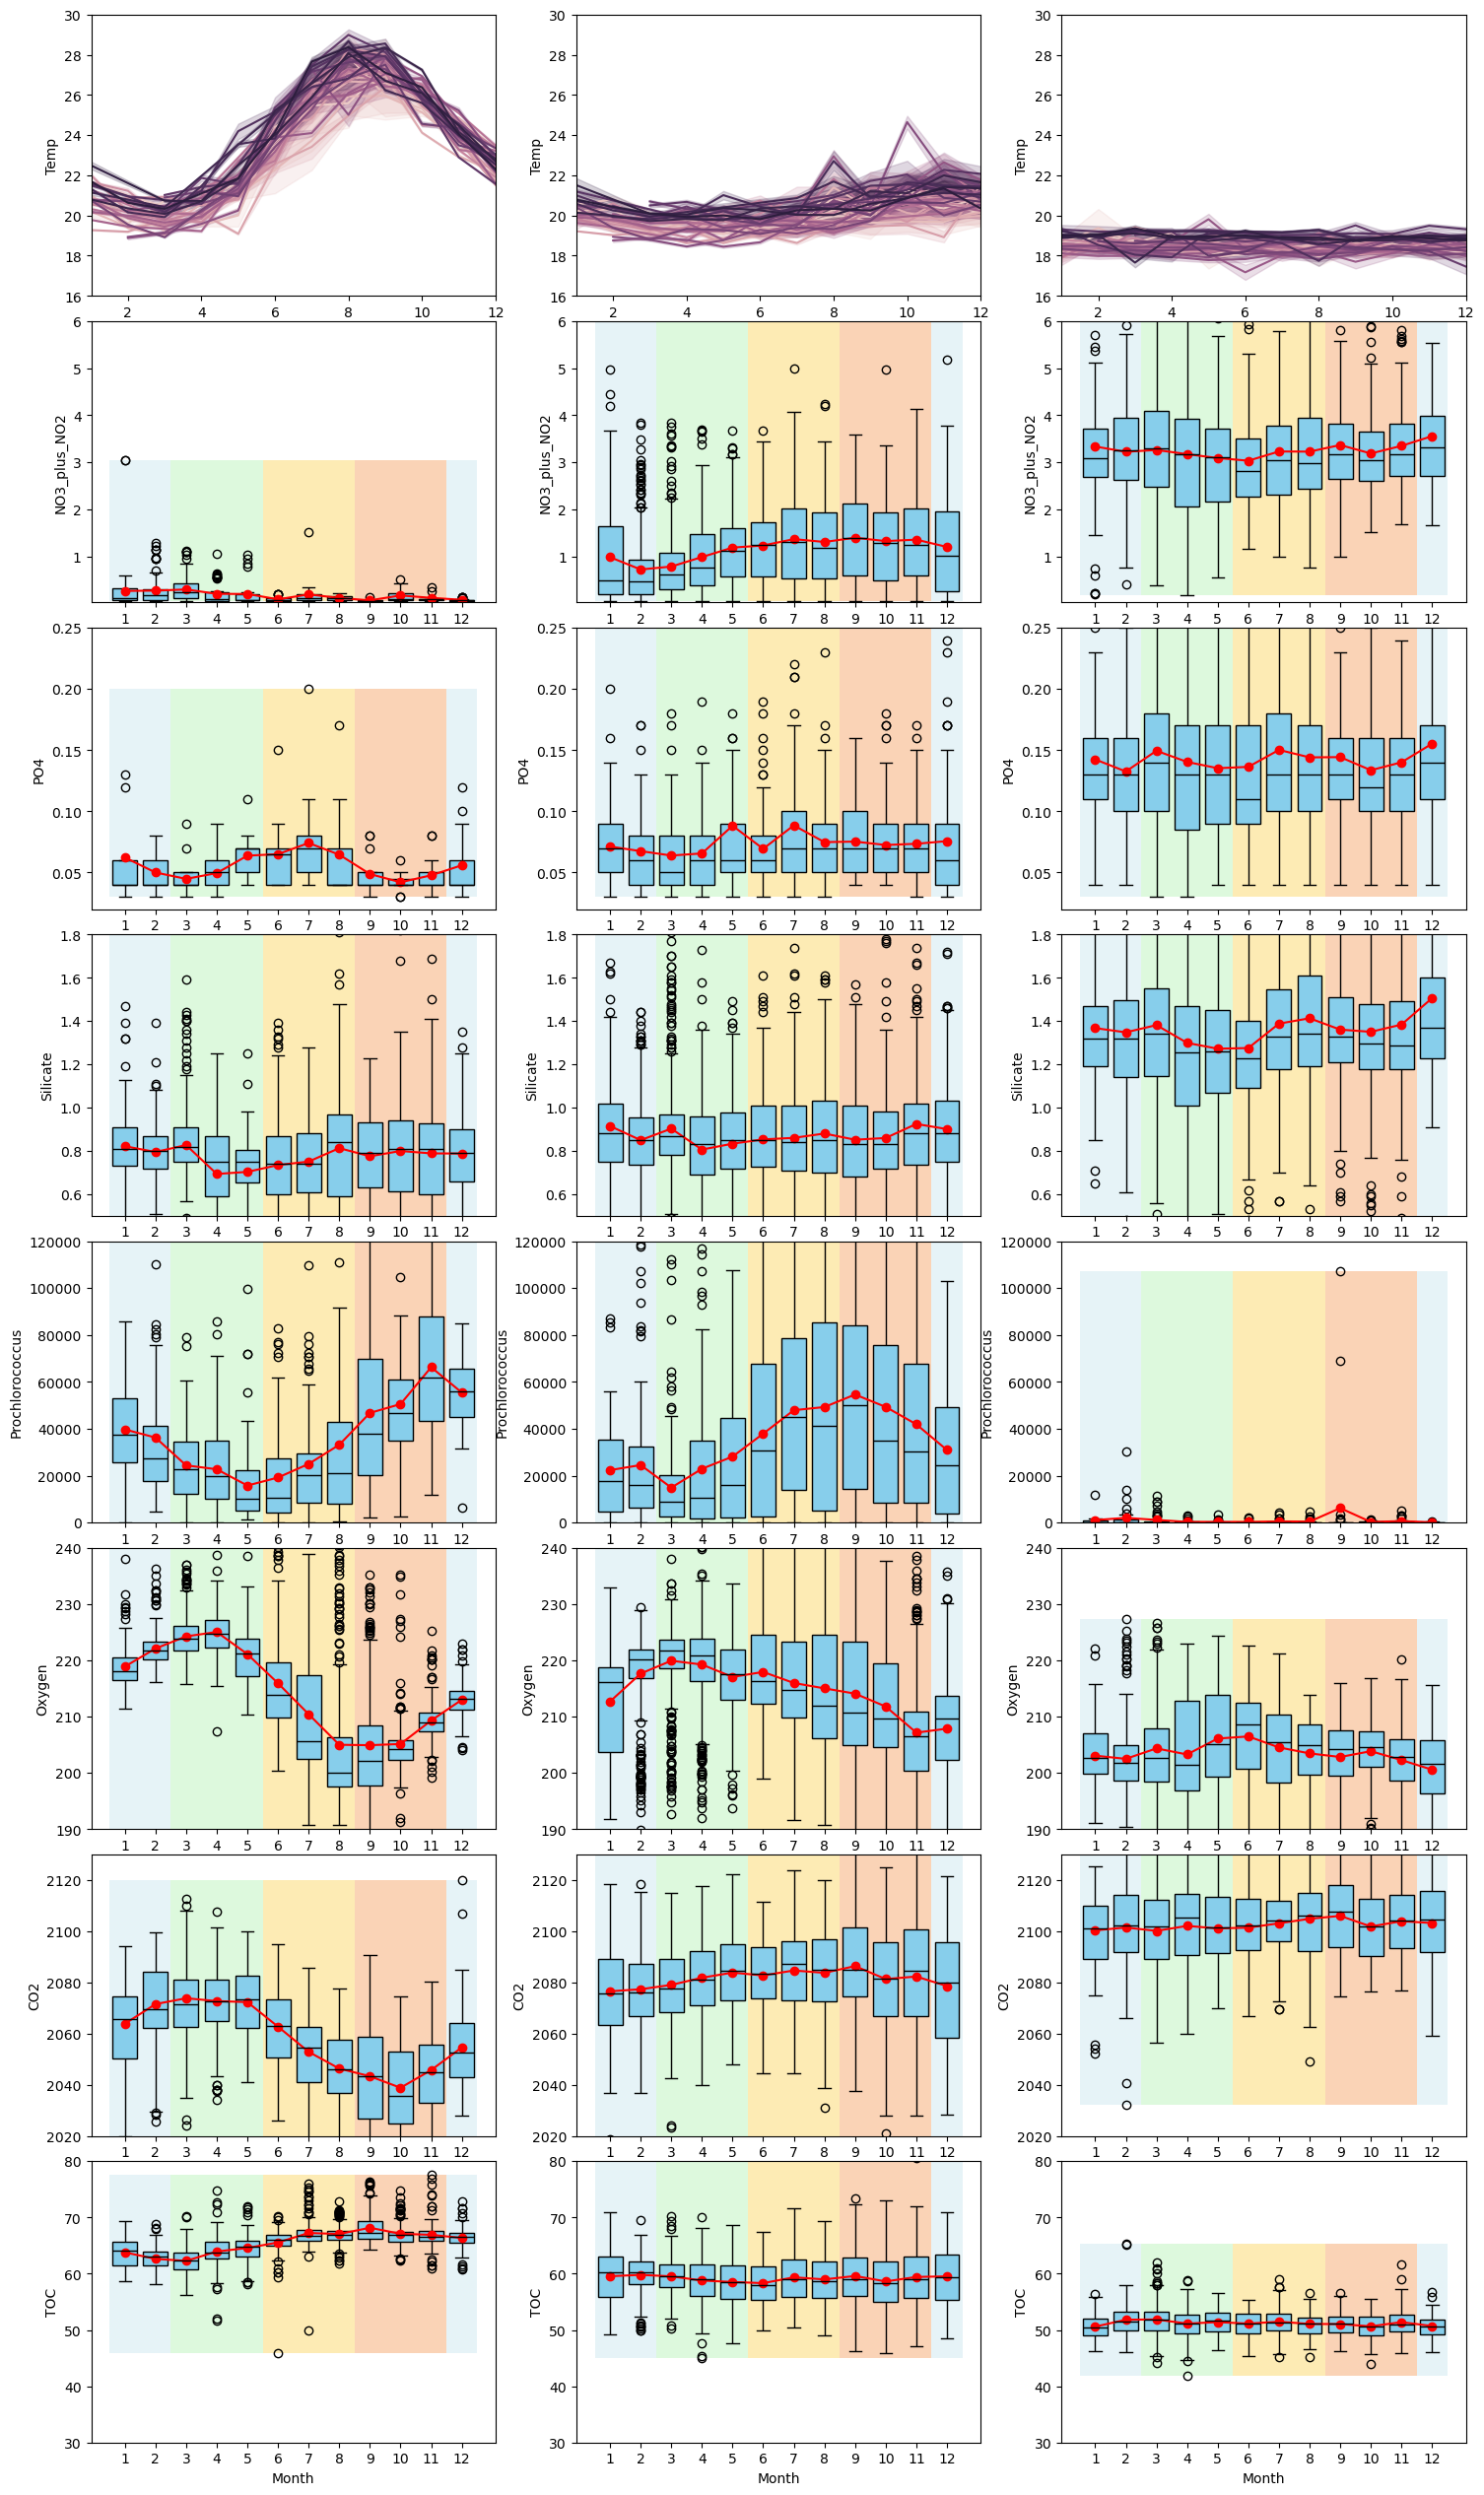

In [583]:
fig = create_parameter_plots(
    datasets=plot_datasets,
    param_config=param_config,
    layout=(8, 3),
    figsize=(18, 32)
)
#plt.savefig("project/MetaRhythms/figures/boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

### trying to calculate MLD

In [315]:
depth = [0,1000]
filtered_df = df[(df['Depth'] >= depth[0]) & (df['Depth'] <= depth[-1])]
filtered_df['YearMonth'] = filtered_df['ISO_DateTime_UTC'].dt.to_period('M')
filtered_df['Month'] = filtered_df['ISO_DateTime_UTC'].dt.month

sigma_df = filtered_df
sigma_df["YearMonth"] = filtered_df["YearMonth"]
sigma_df["Month"] = sigma_df["YearMonth"].dt.month
sigma_df["Year"] = sigma_df["YearMonth"].dt.year

In [326]:
print(filtered_df.Sigma_theta.min())
print(filtered_df.Sigma_theta.max())

22.702
27.768


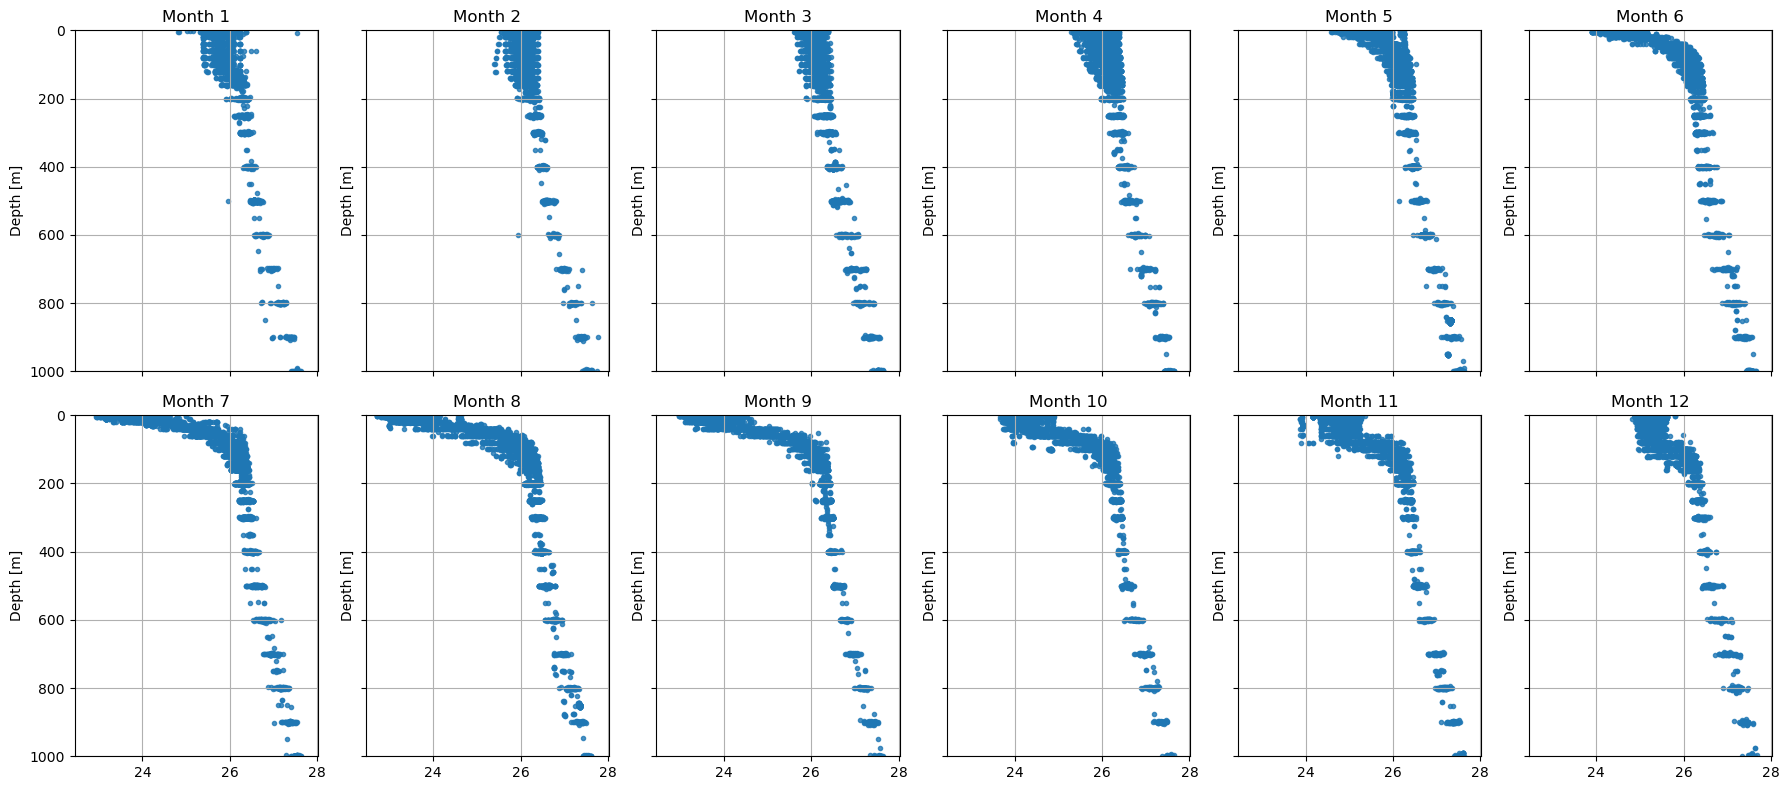

In [334]:
unique_months = sorted(sigma_df.Month.unique())
fig, axes = plt.subplots(2, 6, figsize=(18, 8), sharey=True, sharex=True)

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate over the unique months and plot each month's data
for idx, month in enumerate(unique_months):
    sorted_sigma_df_temp = sigma_df[sigma_df.Month == month].sort_values(by='Depth', ascending=True)[['Sigma_theta', 'Depth']]
    # sorted_sigma_df_x = sigma_df[sigma_df.Month == month].sort_values(by='Depth', ascending=True)[['Temp', 'Depth']]

    ax = axes[idx]
    ax.scatter(sorted_sigma_df_temp['Sigma_theta'], sorted_sigma_df_temp['Depth'], alpha=0.8,marker=".")
    # ax.scatter(sorted_sigma_df_x['Temp'], sorted_sigma_df_x['Depth'], alpha=0.8,marker=".")
    # ax.invert_yaxis()
    ax.set_title(f"Month {month}")
    #ax.set_xlabel("Sigma_theta")
    ax.set_ylabel("Depth [m]")
    ax.grid(True)
    ax.set_ylim(depth[-1],depth[0])

# Hide any unused subplots
for idx in range(len(unique_months), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


In [65]:
np.argmax(np.abs(np.diff(sorted_sigma_df['Sigma_theta'])))

np.int64(9)

In [ ]:

import pandas as pd

# Display the mixed layer depths in a structured format
mld_df = pd.DataFrame(list(mixed_layer_depths.items()), columns=["Month", "Mixed_Layer_Depth"])
import ace_tools as tools; tools.display_dataframe_to_user(name="Mixed Layer Depth by Month", dataframe=mld_df)


In [47]:
sorted_sigma_df

,Sigma_theta,Depth
8607,25.464,0.7
8598,25.499,0.7
8572,25.513,0.7
8596,25.500,0.8
8560,25.472,1.1
...,...,...
42834,26.651,500.0
42863,26.643,500.0
61504,26.594,500.0
61401,26.598,500.0


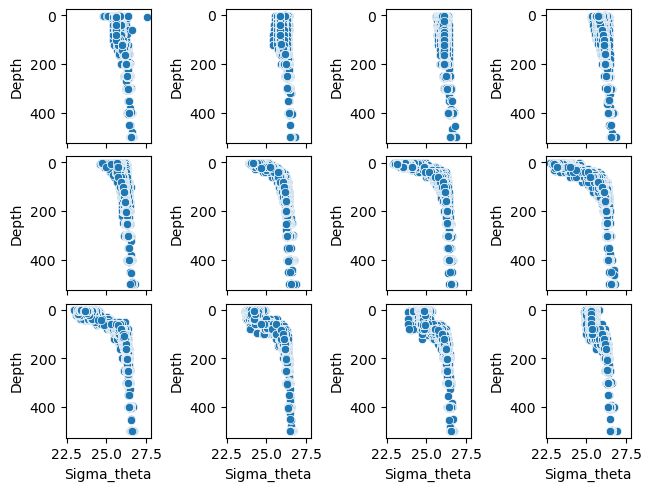

In [12]:
filtered_df = df[(df['Depth'] >= 0) & (df['Depth'] <= 500)]
filtered_df['YearMonth'] = filtered_df['ISO_DateTime_UTC'].dt.to_period('M')
filtered_df['Month'] = filtered_df['ISO_DateTime_UTC'].dt.month

sigma_df = filtered_df
sigma_df["YearMonth"] = filtered_df["YearMonth"]
sigma_df["Month"] = sigma_df["YearMonth"].dt.month
sigma_df["Year"] = sigma_df["YearMonth"].dt.year


#sns.scatterplot(data=sigma_df, x = "Sigma_theta", y = "Depth", hue = "Month").invert_yaxis()

fig, ax = plt.subplots(nrows = 3, ncols = 4, sharey = "col", sharex = "all", layout = "constrained")
for i, month in enumerate(sorted((sigma_df.Month).unique())):
    col = i%4
    if i < 4:
        row = 0
    elif i < 8:
        row = 1
    else:
        row = 2
    
    sns.scatterplot(data=sigma_df[sigma_df.Month == month], x = "Sigma_theta", y = "Depth", ax = ax[row, col]).invert_yaxis()
    #[col.invert_yaxis() for col in ax[0]]